# ***Evaluation of ODE Parameter Estimation***

Import packages

In [1]:
using LGCPGradientMatching

using DataFrames
using Serialization
using Random
using Serialization
using Plots
using Plots.PlotMeasures
using StatsPlots
using StatsBase
using LaTeXStrings

seed = 1
_dir = @__DIR__;
if ~Base.isdir("$(_dir)/../results/img")
    Base.mkdir("$(_dir)/../results/img")
end

[ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]


## ***1. SIR***
Load simulated data and results

In [2]:
open("$(_dir)/../results/exp-5.2.2-SIR_seed$(seed).dat", "r") do io
    global results = Serialization.deserialize(io)
end;

Calculate RMSD

In [3]:
λ0s = [50.0, 100.0, 1000.0]
model_names = ["odemod_coarse", "odemod_fine", "odecox"]

rmsd_g = Dict(name => Dict() for name in model_names)
rmsd_θ = Dict(name => Dict() for name in model_names)

for λ0 in λ0s, name in model_names
    res = results[λ0]
    data, mod, chain = res["data"], res[name].mod, res[name].chain
    rmsd_g[name][λ0], rmsd_θ[name][λ0] = LGCPGradientMatching.calc_rmsd(data, mod, chain)
end

DataFrame for RMSD of g

In [4]:
df_rmsd_g = DataFrame("Scheme" => model_names)
for λ0 in λ0s
    df_rmsd_g[!, "λ0=$(λ0)"] = [rmsd_g[name][λ0] for name in model_names]
end
df_rmsd_g

3×4 DataFrame
 Row │ Scheme         λ0=50.0   λ0=100.0  λ0=1000.0 
     │ String         Float64   Float64   Float64   
─────┼──────────────────────────────────────────────
   1 │ odemod_coarse  0.843014  0.850244   0.453066
   2 │ odemod_fine    1.09032   1.18972    0.351438
   3 │ odecox         0.544792  0.34051    0.179856

DataFrame for RMSD of θ

In [5]:
df_rmsd_θ = DataFrame("Scheme" => model_names)
for λ0 in λ0s
    df_rmsd_θ[!, "λ0=$(λ0)"] = [rmsd_θ[name][λ0] for name in model_names]
end
df_rmsd_θ

3×4 DataFrame
 Row │ Scheme         λ0=50.0   λ0=100.0   λ0=1000.0 
     │ String         Float64   Float64    Float64   
─────┼───────────────────────────────────────────────
   1 │ odemod_coarse  0.657234  0.735093    0.536618
   2 │ odemod_fine    0.643392  0.587541    0.441944
   3 │ odecox         0.378998  0.0702705   0.118796

plot

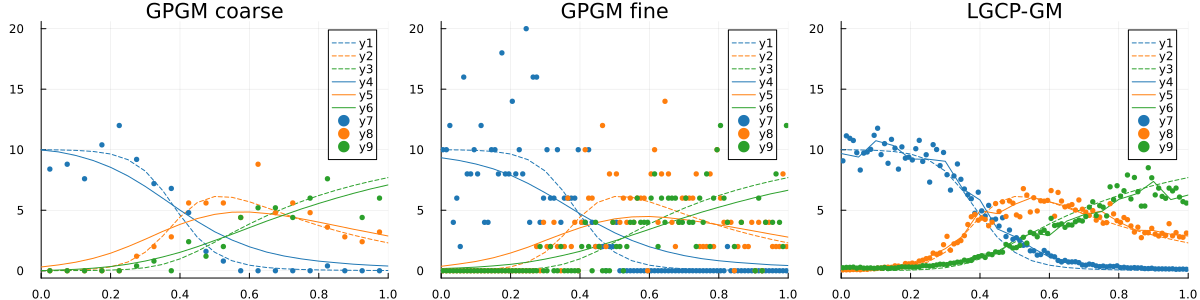

In [6]:
λ0=50.0

data = results[λ0]["data"]
inducing_points = results[λ0]["odecox"].mod.gm.u⁺
gt_g = LGCPGradientMatching.get_ground_truth_g(data, inducing_points)

odemod_c = results[λ0]["odemod_coarse"].mod
odemod_f = results[λ0]["odemod_fine"].mod
odecox = results[λ0]["odecox"].mod

pal = palette(:tab10)[1:3]

plot(
    (
        plot(odemod_c.gm.u⁺, gt_g, ls=:dash, palette=pal);
        plot!(odemod_c.gm.u⁺, odemod_c.gm.X, palette=pal);
        scatter!(odemod_c.gm.t⁺, odemod_c.gm.Y, ms=3, msw=0, palette=pal);
        title!("GPGM coarse")
    ),
    (
        plot(odemod_f.gm.u⁺, gt_g, ls=:dash, palette=pal);
        plot!(odemod_f.gm.u⁺, odemod_f.gm.X, palette=pal);
        scatter!(odemod_f.gm.t⁺, odemod_f.gm.Y, ms=3, msw=0, palette=pal);
        title!("GPGM fine")
    ),
    (
        plot(odecox.gm.u⁺, gt_g, ls=:dash, palette=pal);
        plot!(odecox.gm.u⁺, exp.(odecox.gm.X), palette=pal);
        scatter!(odecox.gm.t⁺, exp.(odecox.gm.Y), ms=3, msw=0, palette=pal);
        title!("LGCP-GM")
    ),
    size=(1200,300),
    layout=(1,3),
    xlims=(0,1),
    link=:both
)

Simulate ODE dynamics with posterior ODE parameter samples

In [7]:
ode_figs = []
event_figs = []
titles = [L"\lambda_0=50", L"\lambda_0=100", L"\lambda_0=1000"]
for i in 1:length(λ0s)
    λ0 = λ0s[i]
    data = results[λ0]["data"]
    push!(event_figs, LGCPGradientMatching.eventplot(data; title=titles[i], alpha=0.2))
    for name in model_names
        res = results[λ0]
        mod, chain = res[name].mod, res[name].chain
        Zs = LGCPGradientMatching.sim_ode_with_posterior_θ_samples(data, mod, chain)
        fig = LGCPGradientMatching.draw_gt_and_sim_ode(data, Zs, qlow=0.125, qhigh=0.875)
        push!(ode_figs, fig)
    end
end

Compare Ground-truth dynamics and simulated dynamics

In [8]:
p_annotate = plot(
    (plot(ticks=:none, axis=false); annotate!(0.5, 0.5, Plots.text("synthesized\nevents", "Times", 12))),
    (plot(ticks=:none, axis=false); annotate!(0.5, 0.5, Plots.text("GPGM\n(T=20)", "Times", 12))),
    (plot(ticks=:none, axis=false); annotate!(0.5, 0.5, Plots.text("GPGM\n(T=100)", "Times", 12))),
    (plot(ticks=:none, axis=false); annotate!(0.5, 0.5, Plots.text("LGCP-GM\n(ours)", "Times", 12))),
    layout=Plots.grid(4,1, heights=[0.09, 0.3, 0.3, 0.31]),
    size=(100, 260)
    )

p = plot(
    event_figs[1], event_figs[2], event_figs[3],

    (plot(ode_figs[1]; xtick=:none, ylims=(0, 10))),
    (plot(ode_figs[4]; ticks=:none, ylims=(0, 10))),
    (plot(ode_figs[7]; ticks=:none, ylims=(0, 10))),

    (plot(ode_figs[2]; xtick=:none, ylims=(0, 10), ylabel="modulation")),
    (plot(ode_figs[5]; ticks=:none, ylims=(0, 10))),
    (plot(ode_figs[8]; ticks=:none, ylims=(0, 10))),

    (plot(ode_figs[3]; xtick=[0.0,0.5,1.0], ylims=(0, 10))),
    (plot(ode_figs[6]; xtick=[0.0,0.5,1.0], ylims=(0, 10), ytick=:none, xlabel="time")),
    (plot(ode_figs[9]; xtick=[0.0,0.5,1.0], ylims=(0, 10), ytick=:none)),

    guidefontfamily="Times",
    tickfontfamily="Times",
    titlefontsize=12,
    tickfontsize=10,
    yticks=[0,5,10],
    grid=:none,
    legend=:none,
    labelfontsize=14,
    topmargin=0mm,
    leftmargin=0mm,
    bottommargin=2mm,
    layout=Plots.grid(4,3, heights=[0.09, 0.3, 0.3, 0.31], widths=[0.34, 0.33, 0.33]),
    size=(600, 320)
)

plot(p_annotate, p, layout=Plots.grid(1,2, widths=[0.2, 0.8]))

Save figure

In [9]:
Plots.png(plot(p, dpi=200), "$(_dir)/../results/img/exp-5.2.2-SIR_seed$(seed).png");

## ***2. Predator-Prey***
Load simulated data and results

In [10]:
open("$(_dir)/../results/exp-5.2.2-PredatorPrey_seed$(seed).dat", "r") do io
    global results = Serialization.deserialize(io)
end;

Calculate RMSD

In [11]:
λ0s = [50.0, 100.0, 1000.0]
model_names = ["odemod_coarse", "odemod_fine", "odecox"]

rmsd_g = Dict(name => Dict() for name in model_names)
rmsd_θ = Dict(name => Dict() for name in model_names)

for λ0 in λ0s, name in model_names
    res = results[λ0]
    data, mod, chain = res["data"], res[name].mod, res[name].chain
    rmsd_g[name][λ0], rmsd_θ[name][λ0] = LGCPGradientMatching.calc_rmsd(data, mod, chain)
end

DataFrame for RMSD of g

In [12]:
df_rmsd_g = DataFrame("Scheme" => model_names)
for λ0 in λ0s
    df_rmsd_g[!, "λ0=$(λ0)"] = [rmsd_g[name][λ0] for name in model_names]
end
df_rmsd_g

3×4 DataFrame
 Row │ Scheme         λ0=50.0   λ0=100.0  λ0=1000.0 
     │ String         Float64   Float64   Float64   
─────┼──────────────────────────────────────────────
   1 │ odemod_coarse  0.520097  0.648556   0.231958
   2 │ odemod_fine    0.620221  0.490116   0.146752
   3 │ odecox         0.51752   0.323381   0.118839

DataFrame for RMSD of θ

In [13]:
df_rmsd_θ = DataFrame("Scheme" => model_names)
for λ0 in λ0s
    df_rmsd_θ[!, "λ0=$(λ0)"] = [rmsd_θ[name][λ0] for name in model_names]
end
df_rmsd_θ

3×4 DataFrame
 Row │ Scheme         λ0=50.0  λ0=100.0  λ0=1000.0 
     │ String         Float64  Float64   Float64   
─────┼─────────────────────────────────────────────
   1 │ odemod_coarse  7.68491   6.09073   13.8109
   2 │ odemod_fine    4.88366   1.86312    2.87152
   3 │ odecox         4.64266   2.23489    1.78591

plot

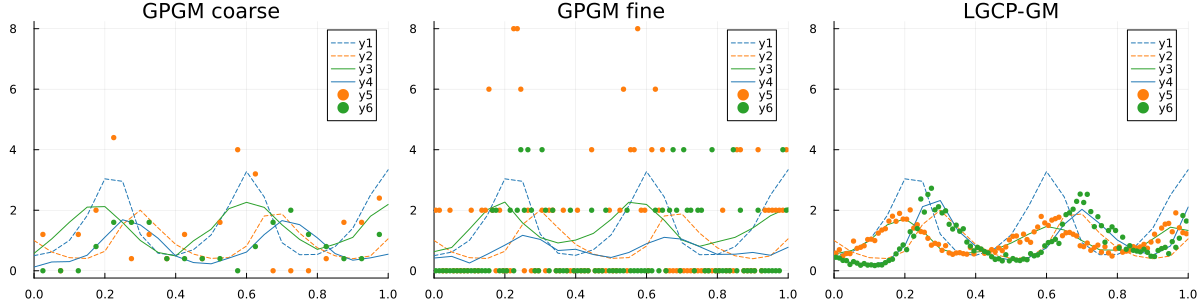

In [14]:
λ0=50.0

data = results[λ0]["data"]
inducing_points = results[λ0]["odecox"].mod.gm.u⁺
gt_g = LGCPGradientMatching.get_ground_truth_g(data, inducing_points)

odemod_c = results[λ0]["odemod_coarse"].mod
odemod_f = results[λ0]["odemod_fine"].mod
odecox = results[λ0]["odecox"].mod

pal = palette(:tab10)[1:3]

plot(
    (
        plot(odemod_c.gm.u⁺, gt_g, ls=:dash, palette=pal);
        plot!(odemod_c.gm.u⁺, odemod_c.gm.X, palette=pal);
        scatter!(odemod_c.gm.t⁺, odemod_c.gm.Y, ms=3, msw=0, palette=pal);
        title!("GPGM coarse")
    ),
    (
        plot(odemod_f.gm.u⁺, gt_g, ls=:dash, palette=pal);
        plot!(odemod_f.gm.u⁺, odemod_f.gm.X, palette=pal);
        scatter!(odemod_f.gm.t⁺, odemod_f.gm.Y, ms=3, msw=0, palette=pal);
        title!("GPGM fine")
    ),
    (
        plot(odecox.gm.u⁺, gt_g, ls=:dash, palette=pal);
        plot!(odecox.gm.u⁺, exp.(odecox.gm.X), palette=pal);
        scatter!(odecox.gm.t⁺, exp.(odecox.gm.Y), ms=3, msw=0, palette=pal);
        title!("LGCP-GM")
    ),
    size=(1200,300),
    layout=(1,3),
    xlims=(0,1),
    link=:both
)

Simulate ODE dynamics with posterior ODE parameter samples

In [15]:
ode_figs = []
event_figs = []
titles = [L"\lambda_0=50", L"\lambda_0=100", L"\lambda_0=1000"]
for i in 1:length(λ0s)
    λ0 = λ0s[i]
    data = results[λ0]["data"]
    push!(event_figs, LGCPGradientMatching.eventplot(data; title=titles[i], alpha=0.2))
    for name in model_names
        res = results[λ0]
        mod, chain = res[name].mod, res[name].chain
        Zs = LGCPGradientMatching.sim_ode_with_posterior_θ_samples(data, mod, chain)
        fig = LGCPGradientMatching.draw_gt_and_sim_ode(data, Zs, qlow=0.125, qhigh=0.875)
        push!(ode_figs, fig)
    end
end

Compare Ground-truth dynamics and simulated dynamics

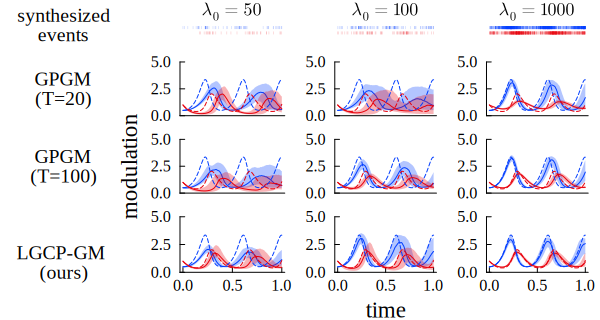

In [16]:
p_annotate = plot(
    (plot(ticks=:none, axis=false); annotate!(0.5, 0.5, Plots.text("synthesized\nevents", "Times", 12))),
    (plot(ticks=:none, axis=false); annotate!(0.5, 0.5, Plots.text("GPGM\n(T=20)", "Times", 12))),
    (plot(ticks=:none, axis=false); annotate!(0.5, 0.5, Plots.text("GPGM\n(T=100)", "Times", 12))),
    (plot(ticks=:none, axis=false); annotate!(0.5, 0.5, Plots.text("LGCP-GM\n(ours)", "Times", 12))),
    layout=Plots.grid(4,1, heights=[0.09, 0.3, 0.3, 0.31]),
    size=(100, 260)
    )

p = plot(
    event_figs[1], event_figs[2], event_figs[3],

    (plot(ode_figs[1]; xtick=:none, ylims=(0, 5))),
    (plot(ode_figs[4]; ticks=:none, ylims=(0, 5))),
    (plot(ode_figs[7]; ticks=:none, ylims=(0, 5))),

    (plot(ode_figs[2]; xtick=:none, ylims=(0, 5), ylabel="modulation")),
    (plot(ode_figs[5]; ticks=:none, ylims=(0, 5))),
    (plot(ode_figs[8]; ticks=:none, ylims=(0, 5))),

    (plot(ode_figs[3]; xtick=[0.0,0.5,1.0], ylims=(0, 5))),
    (plot(ode_figs[6]; xtick=[0.0,0.5,1.0], ylims=(0, 5), ytick=:none, xlabel="time")),
    (plot(ode_figs[9]; xtick=[0.0,0.5,1.0], ylims=(0, 5), ytick=:none)),

    guidefontfamily="Times",
    tickfontfamily="Times",
    titlefontsize=12,
    tickfontsize=10,
    yticks=[0,2.5,5],
    grid=:none,
    legend=:none,
    labelfontsize=14,
    topmargin=0mm,
    leftmargin=0mm,
    bottommargin=2mm,
    layout=Plots.grid(4,3, heights=[0.09, 0.3, 0.3, 0.31], widths=[0.34, 0.33, 0.33]),
    size=(600, 320)
)

plot(p_annotate, p, layout=Plots.grid(1,2, widths=[0.2, 0.8]))

Save figure

In [17]:
Plots.png(plot(p, dpi=200), "$(_dir)/../results/img/exp-5.2.2-PredatorPrey_seed$(seed).png");

## ***3. Competition***
Load simulated data and results

In [18]:
open("$(_dir)/../results/exp-5.2.2-Competition_seed$(seed).dat", "r") do io
    global results = Serialization.deserialize(io)
end;

Calculate RMSD

In [19]:
λ0s = [50.0, 100.0, 1000.0]
model_names = ["odemod_coarse", "odemod_fine", "odecox"]

rmsd_g = Dict(name => Dict() for name in model_names)
rmsd_θ = Dict(name => Dict() for name in model_names)

for λ0 in λ0s, name in model_names
    res = results[λ0]
    data, mod, chain = res["data"], res[name].mod, res[name].chain
    rmsd_g[name][λ0], rmsd_θ[name][λ0] = LGCPGradientMatching.calc_rmsd(data, mod, chain)
end

DataFrame for RMSD of g

In [20]:
df_rmsd_g = DataFrame("Scheme" => model_names)
for λ0 in λ0s
    df_rmsd_g[!, "λ0=$(λ0)"] = [rmsd_g[name][λ0] for name in model_names]
end
df_rmsd_g

3×4 DataFrame
 Row │ Scheme         λ0=50.0   λ0=100.0  λ0=1000.0 
     │ String         Float64   Float64   Float64   
─────┼──────────────────────────────────────────────
   1 │ odemod_coarse  0.488772  0.51449    0.112256
   2 │ odemod_fine    0.554685  0.517476   0.112967
   3 │ odecox         0.454731  0.258852   0.117312

DataFrame for RMSD of θ

In [21]:
df_rmsd_θ = DataFrame("Scheme" => model_names)
for λ0 in λ0s
    df_rmsd_θ[!, "λ0=$(λ0)"] = [rmsd_θ[name][λ0] for name in model_names]
end
df_rmsd_θ

3×4 DataFrame
 Row │ Scheme         λ0=50.0  λ0=100.0  λ0=1000.0 
     │ String         Float64  Float64   Float64   
─────┼─────────────────────────────────────────────
   1 │ odemod_coarse  3.18323   3.34971    2.64573
   2 │ odemod_fine    3.34473   3.04916    2.63581
   3 │ odecox         2.30529   2.2075     2.04651

plot

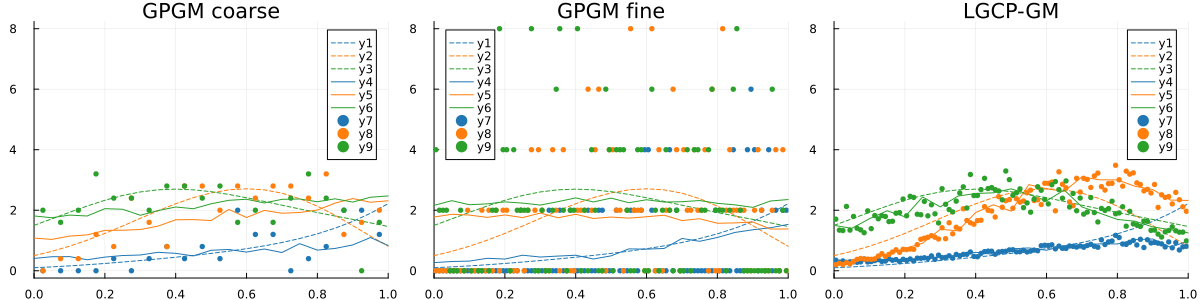

In [22]:
λ0=50.0

data = results[λ0]["data"]
inducing_points = results[λ0]["odecox"].mod.gm.u⁺
gt_g = LGCPGradientMatching.get_ground_truth_g(data, inducing_points)

odemod_c = results[λ0]["odemod_coarse"].mod
odemod_f = results[λ0]["odemod_fine"].mod
odecox = results[λ0]["odecox"].mod

pal = palette(:tab10)[1:3]

plot(
    (
        plot(odemod_c.gm.u⁺, gt_g, ls=:dash, palette=pal);
        plot!(odemod_c.gm.u⁺, odemod_c.gm.X, palette=pal);
        scatter!(odemod_c.gm.t⁺, odemod_c.gm.Y, ms=3, msw=0, palette=pal);
        title!("GPGM coarse")
    ),
    (
        plot(odemod_f.gm.u⁺, gt_g, ls=:dash, palette=pal);
        plot!(odemod_f.gm.u⁺, odemod_f.gm.X, palette=pal);
        scatter!(odemod_f.gm.t⁺, odemod_f.gm.Y, ms=3, msw=0, palette=pal);
        title!("GPGM fine")
    ),
    (
        plot(odecox.gm.u⁺, gt_g, ls=:dash, palette=pal);
        plot!(odecox.gm.u⁺, exp.(odecox.gm.X), palette=pal);
        scatter!(odecox.gm.t⁺, exp.(odecox.gm.Y), ms=3, msw=0, palette=pal);
        title!("LGCP-GM")
    ),
    size=(1200,300),
    layout=(1,3),
    xlims=(0,1),
    link=:both
)

Simulate ODE dynamics with posterior ODE parameter samples

In [23]:
ode_figs = []
event_figs = []
titles = [L"\lambda_0=50", L"\lambda_0=100", L"\lambda_0=1000"]
for i in 1:length(λ0s)
    λ0 = λ0s[i]
    data = results[λ0]["data"]
    push!(event_figs, LGCPGradientMatching.eventplot(data; title=titles[i], alpha=0.2))
    for name in model_names
        res = results[λ0]
        mod, chain = res[name].mod, res[name].chain
        Zs = LGCPGradientMatching.sim_ode_with_posterior_θ_samples(data, mod, chain)
        fig = LGCPGradientMatching.draw_gt_and_sim_ode(data, Zs, qlow=0.125, qhigh=0.875)
        push!(ode_figs, fig)
    end
end

Compare Ground-truth dynamics and simulated dynamics

In [24]:
p_annotate = plot(
    (plot(ticks=:none, axis=false); annotate!(0.5, 0.5, Plots.text("synthesized\nevents", "Times", 12))),
    (plot(ticks=:none, axis=false); annotate!(0.5, 0.5, Plots.text("GPGM\n(T=20)", "Times", 12))),
    (plot(ticks=:none, axis=false); annotate!(0.5, 0.5, Plots.text("GPGM\n(T=100)", "Times", 12))),
    (plot(ticks=:none, axis=false); annotate!(0.5, 0.5, Plots.text("LGCP-GM\n(ours)", "Times", 12))),
    layout=Plots.grid(4,1, heights=[0.09, 0.3, 0.3, 0.31]),
    size=(100, 260)
    )

p = plot(
    event_figs[1], event_figs[2], event_figs[3],

    (plot(ode_figs[1]; xtick=:none, ylims=(0, 5))),
    (plot(ode_figs[4]; ticks=:none, ylims=(0, 5))),
    (plot(ode_figs[7]; ticks=:none, ylims=(0, 5))),

    (plot(ode_figs[2]; xtick=:none, ylims=(0, 5), ylabel="modulation")),
    (plot(ode_figs[5]; ticks=:none, ylims=(0, 5))),
    (plot(ode_figs[8]; ticks=:none, ylims=(0, 5))),

    (plot(ode_figs[3]; xtick=[0.0,0.5,1.0], ylims=(0, 5))),
    (plot(ode_figs[6]; xtick=[0.0,0.5,1.0], ylims=(0, 5), ytick=:none, xlabel="time")),
    (plot(ode_figs[9]; xtick=[0.0,0.5,1.0], ylims=(0, 5), ytick=:none)),

    guidefontfamily="Times",
    tickfontfamily="Times",
    titlefontsize=12,
    tickfontsize=10,
    yticks=[0,2.5,5],
    grid=:none,
    legend=:none,
    labelfontsize=14,
    topmargin=0mm,
    leftmargin=0mm,
    bottommargin=2mm,
    layout=Plots.grid(4,3, heights=[0.09, 0.3, 0.3, 0.31], widths=[0.34, 0.33, 0.33]),
    size=(600, 320)
)

plot(p_annotate, p, layout=Plots.grid(1,2, widths=[0.2, 0.8]))

Save figure

In [25]:
Plots.png(plot(p, dpi=200), "$(_dir)/../results/img/exp-5.2.2-Competition_seed$(seed).png");

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*